# Упражнения
В этом упражнении рассматривается прогноз SARIMA, аналогичный тому, который был сделан для набора данных $CO_2$.



In [ ]:
!pip install pmdarima

In [ ]:
# 
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
# import warnings
# warnings.filterwarnings("ignore")

# Загрузка датасета
df = pd.read_csv(r'C:\Users\HUAWEI\OneDrive\Документы\Аналитик данных/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


В <tt>df</tt>  348 записей и 1 колонка. Данные представляют собой численность сотрудников в тысячах человек в среднем за месяц с января 1990 года по декабрь 2018 года.

### 1. Постройте график временного ряда


[Text(0.5, 1.0, 'California Hospitality Industry Employees'),
 Text(0.5, 0, ' '),
 Text(0, 0.5, 'Thousands of Persons')]

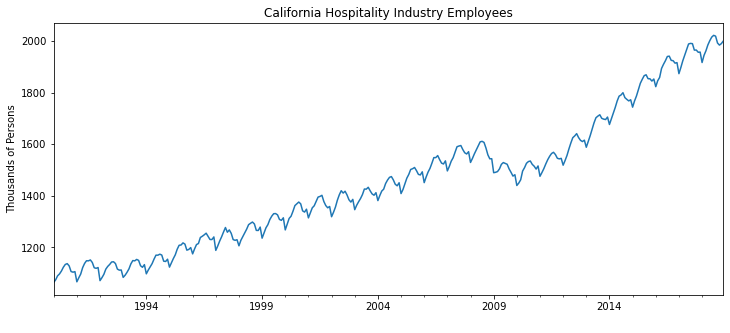

In [ ]:
ax = df['Employees'].plot(figsize=(12,5))
ax.autoscale(axis='x',tight=True)
ax.set(title = 'California Hospitality Industry Employees', xlabel = ' ', ylabel = 'Thousands of Persons')   # указания к названиям графика и осей


На графике виден в целом положительный тренд роста числа сотрудников. Однако в 2009-2010 гг виден спад. Вероятная причина - мировой финансовый кризис.

### 2. Выполните ETS декомпозицию
Используя аддитивную модель ('additive').

Отделяем тренд от сезонных и остаточных компонентов. Используем аддитивную модель т.к. амплитуда колебаний сезонности из года в год не меняется.

Выполняем декомпозицию временного ряда на 4 составляющих:
1) временной ряд
2) тренд
3) сезонность
4) остатки

In [ ]:
r = seasonal_decompose(df, model='additive')

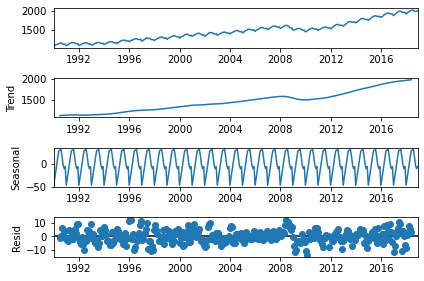

In [ ]:
r.plot();

Видим четко выраженную годовую сезонность

### 3. Запустите <tt>pmdarima.auto_arima</tt> чтобы получить набор параметров
Это может занять некоторое время, так как необходимо оценить множество комбинаций.

In [ ]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()   # указываем наличие сезонности и устанавливаем период сезонности - 1 год

C:\Users\HUAWEI\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,1)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\HUAWEI\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\HUAWEI\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\HUAWEI\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\HUAWEI\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 690, in fit
    mlefit = super(MLEModel, self).fit(star

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Mon, 13 Dec 2021   AIC                           2208.504
Time:                                      21:18:23   BIC                           2231.600
Sample:                                           0   HQIC                          2217.700
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9245      0.045     20.564      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.518      0.000      -1.081      -0.807
ma.L2          0.1287      0.060      2.139      0.032       0.011       0.247
ar.S.L12       0.9972      0.001    703.453      0.000       0.994       1.000
ma.S.L12      -0.7491      0.043    -17.334      0.000      -0.834      -0.664
sigma2        29.2966      1.717     17.062      0.000      25.931      32.662
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Подобранная модель SARIMA - SARIMAX(1, 1, 2)x(1, 0, [1], 12) . Далее по тексту будем называть ее "Оптимальной моделью".
Мы также будем использовать модель с предложенными параметрами : (0,1,0) с сезонностью (2,0,0,12). Далее по тексту будем называть ее "Предложенная модель".
И далее сравним результаты обеих моделей.

Ожидаемый результат ARIMA (0,1,0) с сезонностью (2,0,0,12).
### 4. Разделите данные на train/test 
Установите один год (12 записей) для тестирования. Есть несколько способов сделать это!

In [ ]:
train = df.iloc[:len(df)-12]   
test = df.iloc[len(df)-12:]   # в качестве тестовой выборки берем последние 12 месяцев

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 5. Обучите SARIMA(0,1,0)(2,0,0,12) на train

In [ ]:
model1 = SARIMAX(train['Employees'],order=(1, 1, 2),seasonal_order=(1, 0, 1, 12))
results1 = model1.fit()   # обучаем оптимальную модель на тренировочной выборке на полученных параметрах
results1.summary()

C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Mon, 13 Dec 2021   AIC                           2128.116
Time:                                      22:06:13   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9242      0.043     21.279      0.000       0.839       1.009
ma.L1         -0.9585      0.071    -13.553      0.000      -1.097      -0.820
ma.L2          0.1498      0.061      2.449      0.014       0.030       0.270
ar.S.L12       0.9973      0.001    729.001      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.153      0.000      -0.838      -0.666
sigma2        28.7643      1.684     17.078      0.000      25.463      32.065
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# обучаем предложенную модель
model2 = SARIMAX(train['Employees'],order=(0, 1, 0),seasonal_order=(2, 0, 0, 12))   # изменяем параметры на предложенные
results2 = model2.fit()   # обучаем на тренировочной выборке
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Mon, 13 Dec 2021   AIC                           2196.814
Time:                                    22:06:22   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                56.66
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видим изменения информационных объектов после изменения параметров модели

### 6. Получите прогнозируемые значения

In [ ]:
# задаем точки начала и конца в тестовом множестве
start=len(train)   # первая точка
end=len(train)+len(test)-1   # последняя точка


In [ ]:
#предсказываем значения,передав оптимальной модели results1 точки начала и окончания
predictions1 = results1.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12)')

In [ ]:
#предсказываем значения,передав предложенной модели results2 точку начала и окончания
predictions2 = results2.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(0, 1, 0)x(2, 0, 0, 12)')

<AxesSubplot:xlabel='Date'>

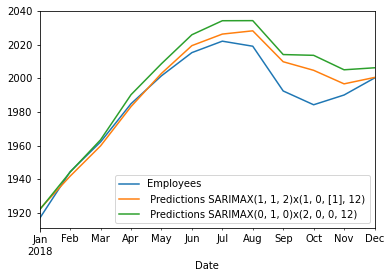

In [ ]:
# сравниваем результаты оптимальной и предложенной моделей
test['Employees'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)

Видим, что результаты оптимальной модели ближе к реальным, чем результаты предложенной модели.

### 7. Нарисуйте графики прогнозируемых и известных значений


[Text(0.5, 1.0, 'California Hospitality Industry Employees, Optimal'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Thousands of Persons')]

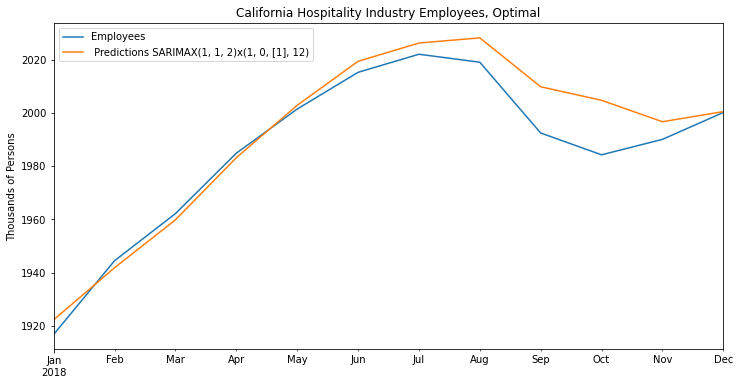

In [ ]:
#Строим график оптимальной модели
ax = test['Employees'].plot(legend=True, figsize=(12,6))
predictions1.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(title = 'California Hospitality Industry Employees, Optimal', xlabel= '', ylabel= 'Thousands of Persons')   # указываем названия графика и осей

[Text(0.5, 1.0, 'California Hospitality Industry Employees, Suggested'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Thousands of Persons')]

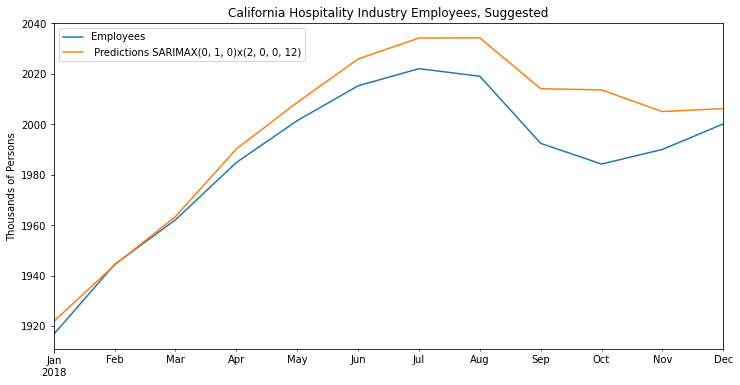

In [ ]:
# строим график предложенной модели
ax2 = test['Employees'].plot(legend=True, figsize=(12,6))
predictions2.plot(legend=True)
ax2.autoscale(axis='x',tight=True)
ax2.set(title = 'California Hospitality Industry Employees, Suggested', xlabel= '', ylabel= 'Thousands of Persons')   # указываем названия графика и осей

### 8. Оцените качество модели с помощью MSE и RMSE


In [ ]:
#Оцениваем оптимальную модель методом MSE (Среднеквадратическая ошибка Mean Square Error) и RMSE (Среднеквадратическое отклонение Root Mean Square Error)
mse_error1 = mean_squared_error(test['Employees'], predictions1)
rmse_error1 = rmse(test['Employees'], predictions1)
print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 12) MSE Error: {mse_error1:11.10}')   # 11 - кол-во символов (с точкой), 10 - после точки
print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 12) RMSE Error: {rmse_error1:11.10}')

SARIMAX(1, 1, 2)x(1, 0, [1], 12) MSE Error: 77.65445007
SARIMAX(1, 1, 2)x(1, 0, [1], 12) RMSE Error: 8.812176239


In [ ]:
#те же вычисления для предложенной модели
mse_error2 = mean_squared_error(test['Employees'], predictions2)
rmse_error2 = rmse(test['Employees'], predictions2)
print(f'SARIMAX(0, 1, 0)x(2, 0, 0, 12) MSE Error: {mse_error2:11.10}')  
print(f'SARIMAX(0, 1, 0)x(2, 0, 0, 12) RMSE Error: {rmse_error2:11.10}')

SARIMAX(0, 1, 0)x(2, 0, 0, 12) MSE Error: 182.8506669
SARIMAX(0, 1, 0)x(2, 0, 0, 12) RMSE Error: 13.52222862


Как видим, значения среднеквадратической ошибки и среднеквадратического отклонения для оптимальной и предлодженной модели отличаются существенно. Для оптимальной модели значения меньше, вывод - модель работает лучше.

### 9. Натренируйте модель на полном датасете и предскажите на год вперед

In [ ]:
#Для предсказания мы берем оптимальную модель, т.к. она более точная, что показали значения MSE и RMSE. 
# Так как мы не знаем данных будущего, то обучаем модель на всем датасете (обучение без учителя)
model1 = SARIMAX(df['Employees'],order=(1, 1, 2),seasonal_order=(1, 0, 1, 12))   # подставляем параметры оптимальной модели
results1 = model.fit()
results1.summary()

C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HUAWEI\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Mon, 13 Dec 2021   AIC                           2128.116
Time:                                      22:43:31   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9242      0.043     21.279      0.000       0.839       1.009
ma.L1         -0.9585      0.071    -13.553      0.000      -1.097      -0.820
ma.L2          0.1498      0.061      2.449      0.014       0.030       0.270
ar.S.L12       0.9973      0.001    729.001      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.153      0.000      -0.838      -0.666
sigma2        28.7643      1.684     17.078      0.000      25.463      32.065
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#задаем точки для прогноза на следующий год
fcast = results1.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(1, 1, 2)x(1, 0, [1], 12) Forecast')

### 10. Постройте график предсказаний и график исходных данных


<AxesSubplot:>

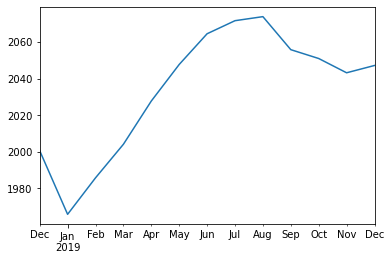

In [ ]:
# Строим график прогноза на год вперед
fcast.plot()
# df['Employees'][-1]

[Text(0.5, 1.0, 'California Hospitality Industry Employees + FORECAST'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Thousands of Persons')]

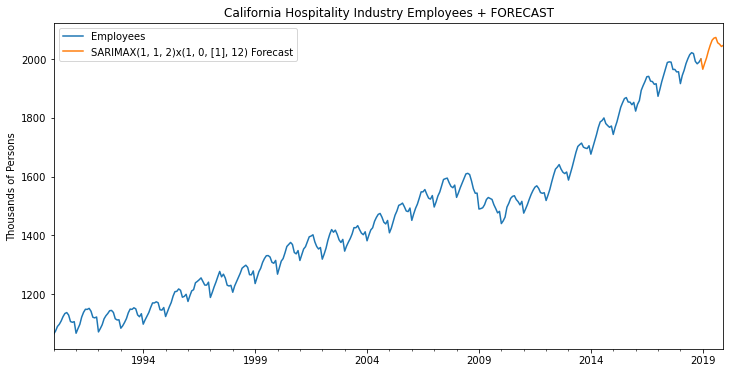

In [ ]:
# Объединяем прогноз с существующими данными
ax = df['Employees'].plot(legend=True, figsize=(12,6)) 
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
# добавляем названия графика и осей
ax.set(title = 'California Hospitality Industry Employees + FORECAST', xlabel= '', ylabel= 'Thousands of Persons')